In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
sns.set()

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)

import calendar
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
# Figure Size
from pylab import rcParams
rcParams['figure.figsize'] = 13, 9

# EDA & Visualizations

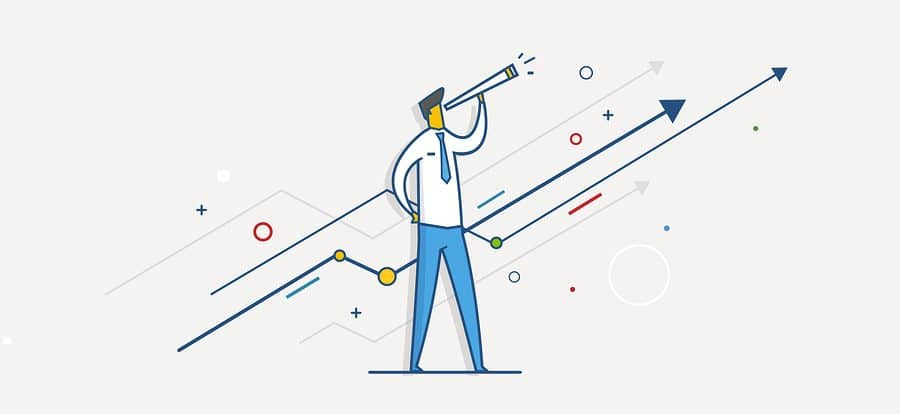

> * You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.
> * Data is available at a daily level, metric is Units Sold

In [ ]:
# Data Load
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv')
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv')
samp = pd.read_csv('../input/demand-forecasting-kernels-only/sample_submission.csv')

# train = pd.read_csv('../Data/Store Item Demand Forecasting/train.csv')
# test = pd.read_csv('../Data/Store Item Demand Forecasting/test.csv')
# samp = pd.read_csv('../Data/Store Item Demand Forecasting/sample_submission.csv')

In [ ]:
# Datatype conversions & basic formatting

train.date = pd.to_datetime(train.date)
train.set_index('date', inplace=True)

test.date = pd.to_datetime(test.date)
test.set_index('date', inplace=True)
test_sub = test.copy()

## Visualizations - One Store

In [ ]:
the_store = 1
the_item = 2

In [ ]:
# Filtering Data for the store and item, Plotting
store_item_data = train[(train.store == the_store) & (train.item == the_item)]

store_item_data[['sales']].plot(figsize=(13, 7))
plt.title("Time Series Plot of Store {} & Item {} - Train Set".format(the_store, the_item));

> * Seasonality is fairly the same for all five years 
> * There seems to be a mid-year promotion in which the sales are at the maximum
> * Trend - gradual increase year by year

In [ ]:
store_item_data.head()

In [ ]:
# Time Series Decomposition
series = store_item_data['sales']
result = seasonal_decompose(series, model='additive', freq=365)
result.plot();
plt.title("Time Series Decomposition Plot - All Data");

In [ ]:
# Time Series Decomposition - Subset
series = store_item_data['sales']['2013-01':'2014-12']
result = seasonal_decompose(series, model='additive', freq=365)
result.plot();
plt.title("Time Series Decomposition Plot - 2013-2014");

In [ ]:
# Mean Sale of Various Items
train[train.store == the_store].groupby(['item']).mean()[['sales']].plot.bar(figsize=(13, 7));
plt.title("Mean Sales of Items within Store {}".format(the_store));

> * Significant Variation in the Average Sale across Items in the same Store.
> * Opens up the scope of Hierarchial Clustering/K Means Clustering here, if we're grouping stores together for forecasting.

In [ ]:
store_list = list(train.store.unique())

In [ ]:
# Adding Seasonality Measures - DOW, DOM, WOM, WOY
def add_seasonality_components(data):

    data['day_week'] = data.index.weekday_name.astype(str)

    data['day_month'] = data.index.day

    data['week_month'] = data['day_month'].map(lambda x :week_num(x))
    
    data['day_month'] = data['day_month'].astype(str)

    data['week_year'] = data.index.week.astype(str)
    
    data['month'] = data.index.month.astype(str)
    
    data['year'] = data.index.year

    return data

In [ ]:
# Calculate Error
def error_calc(data, target_eq_1, pred_col_name):
       
    df = data.copy(deep=True)
    
    df['abs_deviation'] = abs(df[target_eq_1[0]] - df[pred_col_name])
    
    df['percent_deviation'] = df.abs_deviation/abs(df[target_eq_1[0]])
    
    df['percent_deviation'].replace([np.inf, -np.inf], 0, inplace=True)
    
    mae = df.abs_deviation.mean()
    
    mape = df.percent_deviation.mean()*100
    
    return mae, mape

In [ ]:
# Week Number
def week_num(x):
    if x < 8:
        return("First")
    if (x >= 8) & (x <15):
        return("Second")
    if (x >= 15) & (x <22):
        return("Third")
    if (x >= 22) & (x < 28):
        return("Fourth")
    if (x >= 28):
        return("Fifth")

In [ ]:
train = add_seasonality_components(train)
test = add_seasonality_components(test)

In [ ]:
error_log = pd.DataFrame()
log_cols = ['store', 'item', 'train_mae', 'train_mape']

In [ ]:
results = pd.DataFrame()

### Adding Rolling Metrics

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
all_data = train.append(test)

In [ ]:
all_data.head()

In [ ]:
all_data['date'] = all_data.index

In [ ]:
sort_by_cols = ['store', 'item', 'day_week', 'date']

In [ ]:
all_data.sort_values(sort_by_cols, inplace=True)

In [ ]:
f = lambda x: x.rolling(4, min_periods=1).sum().shift(1)

In [ ]:
test = all_data.head(10000)

In [ ]:
all_data.tail(10)

In [ ]:
sort_by_cols = ['store', 'item', 'day_week']

In [ ]:
all_data['rolling_4week_sum'] = all_data.groupby(sort_by_cols, as_index=False)[['sales']].apply(f)

In [ ]:
test.groupby(sort_by_cols, as_index=False)[['sales']].apply(f)

In [ ]:
for the_store in store_list:
    print("Store : {}".format(the_store))
    store_data = pd.DataFrame()
    store_data = train[train.store == the_store]
    
    item_list = list(store_data.item.unique())
    
    for the_item in item_list:
#         print("Item : {}".format(the_item))
        
        # Filtering Train Set
        train_store_item_data = store_data[store_data.item == the_item]
        
        # Filtering Test Set
        filter_condn = (test.store == the_store) & (test.item == the_item)
        test_store_item_data = test[filter_condn]
        
        # Features and Target
        features = ['day_week', 'day_month', 'week_month', 'week_year', 'month']
        target = ['sales']
        
        pred_col_name = target[0] + '_pred'
        
        
        # Train & Test Split
        x_train, y_train = train_store_item_data[features], train_store_item_data[target]
        x_train = pd.get_dummies(x_train)
        
        x_test = test_store_item_data[features]
        x_test = pd.get_dummies(x_test)
        
        # Some categories in train set are not always present in test set, adding them with all zeros
        for the_col in x_train.columns:
            if the_col not in x_test.columns:
                x_test[the_col] = 0

        x_test = x_test[x_train.columns]
        
        # Create a base model
        model = RandomForestRegressor() 
        
        model.fit(x_train, y_train)
        
        y_train[pred_col_name] = model.predict(x_train)
        
        # Error Calculation - Train Set
        train_mae, train_mape = error_calc(y_train, target, pred_col_name)

        log_entry = pd.DataFrame([[the_store, the_item, train_mae, train_mape]], columns=log_cols)
        
        error_log = error_log.append(log_entry)
        
        
        # Predictions for Test Set
        test_store_item_data[target[0]] = model.predict(x_test)
        
        
        results = results.append(test_store_item_data[['id', 'sales']])
        
#         break
        
#     break
print("Run Complete...")

In [ ]:
error_log.head()

In [ ]:
print("Mean Absolute and Percentage Errors as follows : ")
error_log.mean()[2:]

In [ ]:
results.shape

In [ ]:
# results.to_csv('../Results/submission.csv', index=False)
results.to_csv('submission.csv', index=False)